## Import Library

In [ ]:
# Import library untuk manipulasi data
import pandas as pd  # Untuk memanipulasi dan menganalisis data dalam bentuk tabel (DataFrame)
import numpy as np   # Untuk operasi numerik dan array

# Import library untuk visualisasi data
import matplotlib.pyplot as plt  # Untuk membuat grafik dan plot
import seaborn as sns            # Untuk visualisasi statistik yang lebih menarik berbasis matplotlib

# Import preprocessing dari sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
# LabelEncoder: untuk mengubah label kategori menjadi angka
# StandardScaler: untuk menormalkan fitur ke skala standar (mean=0, std=1)

# Import metrik evaluasi model
from sklearn.metrics import classification_report, confusion_matrix
# classification_report: memberikan metrik akurasi, presisi, recall, dan f1-score
# confusion_matrix: menampilkan jumlah prediksi benar/salah dalam format matriks

# Import library TensorFlow dan Keras untuk deep learning
import tensorflow as tf

# Import model Sequential dari Keras
from tensorflow.keras.models import Sequential  # Model neural network berlapis linear (stacked)

# Import layer-layer yang umum digunakan dalam model
from tensorflow.keras.layers import Dense, Dropout  # Dense: layer fully connected, Dropout: regularisasi untuk mencegah overfitting

# Import callback untuk menghentikan pelatihan dini dan menyimpan model terbaik
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping: menghentikan training jika loss/val_loss tidak membaik
# ModelCheckpoint: menyimpan model terbaik saat training

# Import utilitas Keras untuk mengubah label ke one-hot encoding
from tensorflow.keras.utils import to_categorical

# Import layer tambahan untuk stabilisasi training
from tensorflow.keras.layers import BatchNormalization  # Membantu mempercepat dan menstabilkan training neural network

# Import regularizer untuk mencegah overfitting
from tensorflow.keras import regularizers  # Digunakan untuk L1, L2 regularisasi pada bobot

## === GPU SETUP ===

In [ ]:
# Menampilkan daftar perangkat GPU yang tersedia pada sistem
print("=== GPU Devices ===")
print(tf.config.list_physical_devices('GPU'))

# Mengaktifkan memory growth pada GPU agar TensorFlow tidak mengalokasikan seluruh memori sekaligus
# Ini berguna untuk menghindari masalah over-allocate memory, terutama pada server DGX atau mesin multi-GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth harus diaktifkan sebelum GPU dipakai TensorFlow
        print(e)

# === LOAD DATA ===
# Membaca dataset dari file CSV ke dalam pandas DataFrame
train_df = pd.read_csv('train.csv')  # Data pelatihan
val_df = pd.read_csv('val.csv')      # Data validasi
test_df = pd.read_csv('test.csv')    # Data pengujian

# === PREPROCESSING ===
# Encoding label kategori menjadi angka untuk digunakan model
# Menggabungkan semua data kategori dari train, val, dan test agar LabelEncoder mengenali semua kelas
all_kategori = pd.concat([train_df['Kategori'], val_df['Kategori'], test_df['Kategori']])
le_kat = LabelEncoder().fit(all_kategori)  # Melatih encoder pada semua label

# Menerapkan encoding kategori ke setiap dataset
train_df['Kategori_enc'] = le_kat.transform(train_df['Kategori'])
val_df['Kategori_enc'] = le_kat.transform(val_df['Kategori'])
test_df['Kategori_enc'] = le_kat.transform(test_df['Kategori'])

In [ ]:
# === SCALE RPN FEATURE ===
# Menggabungkan kolom 'RPN' dari train, val, dan test untuk melakukan fitting scaler secara menyeluruh
scaler = StandardScaler().fit(
    pd.concat([train_df[['RPN']], val_df[['RPN']], test_df[['RPN']]])
)

# Menerapkan scaling pada masing-masing dataset agar fitur RPN berada dalam skala standar (mean=0, std=1)
train_df['RPN_scaled'] = scaler.transform(train_df[['RPN']])
val_df['RPN_scaled'] = scaler.transform(val_df[['RPN']])
test_df['RPN_scaled'] = scaler.transform(test_df[['RPN']])

# === INPUT FEATURES ===
# Mengambil fitur yang sudah diproses untuk dimasukkan ke model: kategori (encoded) dan RPN (scaled)
X_train = train_df[['Kategori_enc', 'RPN_scaled']].values
X_val = val_df[['Kategori_enc', 'RPN_scaled']].values
X_test = test_df[['Kategori_enc', 'RPN_scaled']].values

# === ENCODE TARGET VARIABLE 'Resiko' ===
# Melatih LabelEncoder pada data training untuk mengubah label kategori target menjadi angka
le_resiko = LabelEncoder().fit(train_df['Resiko'])

# Mengubah label target menjadi one-hot encoding untuk model klasifikasi multi-kelas
y_train = to_categorical(le_resiko.transform(train_df['Resiko']))
y_val = to_categorical(le_resiko.transform(val_df['Resiko']))

# Untuk test, simpan label asli dalam bentuk integer (untuk evaluasi nanti)
y_test = le_resiko.transform(test_df['Resiko'])
# Simpan juga daftar nama kelas asli (untuk interpretasi hasil)
y_test_label_names = le_resiko.classes_

# === CALLBACKS ===
# EarlyStopping untuk menghentikan training jika validasi loss tidak membaik dalam 100 epoch,
# dan mengembalikan bobot model terbaik selama training
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan validasi loss
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# === DEFINISI MODEL SEQUENTIAL ===
model = Sequential()

# Layer Dense pertama dengan 128 neuron, fungsi aktivasi ReLU, input shape sesuai jumlah fitur (2)
model.add(Dense(128, activation='relu', input_shape=(2,)))
model.add(BatchNormalization())  # Normalisasi batch untuk stabilisasi dan percepatan training
model.add(Dropout(0.25))         # Dropout 25% untuk mengurangi overfitting

# Layer-layer berikutnya dengan jumlah neuron berkurang bertahap, tiap layer diikuti BatchNorm dan Dropout
model.add(Dense(96, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(80, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Output layer dengan neuron sebanyak kelas target, fungsi aktivasi softmax untuk probabilitas multi kelas
model.add(Dense(y_train.shape[1], activation='softmax'))

# Kompilasi model menggunakan optimizer Adam dan loss categorical crossentropy (multi-class classification)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === TRAINING MODEL ===
# Melatih model dengan data training dan validasi, batch size 32, maksimum 500 epoch
# Menggunakan callbacks EarlyStopping dan ModelCheckpoint
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=32,
                    callbacks=[early_stop, checkpoint])

# === PREDIKSI PADA DATA TEST ===
# Menghasilkan prediksi probabilitas untuk setiap kelas
y_pred_proba = model.predict(X_test)

# Mengubah probabilitas menjadi label kelas dengan mengambil indeks nilai tertinggi (argmax)
y_pred = np.argmax(y_pred_proba, axis=1)

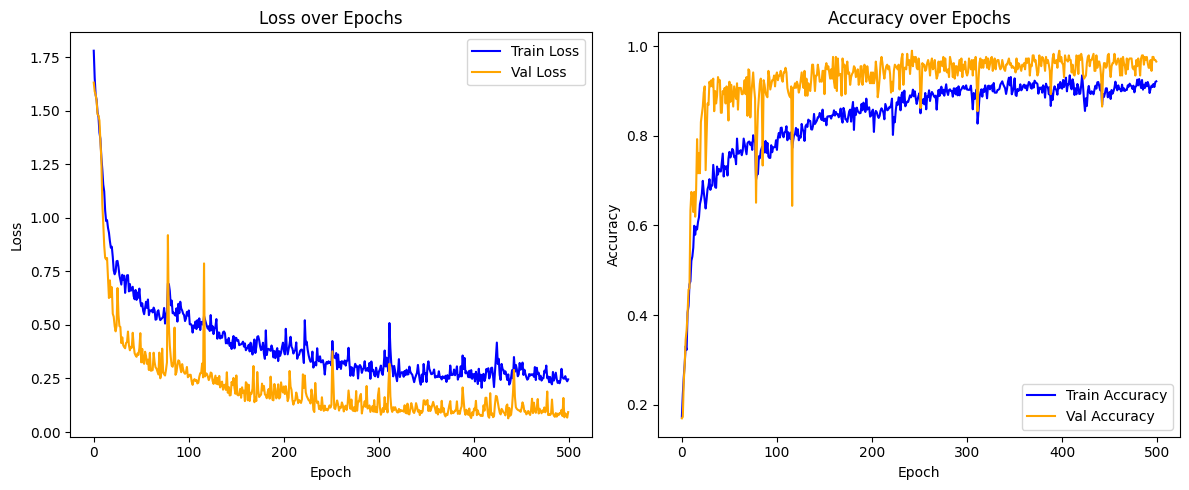

In [ ]:
# Membuat figure dengan ukuran lebar 12 dan tinggi 5 inci
plt.figure(figsize=(12, 5))

# Subplot pertama: Grafik Loss selama epoch
plt.subplot(1, 2, 1)  # 1 baris, 2 kolom, plot ke-1
plt.plot(history.history['loss'], label='Train Loss', color='blue')       # Loss training
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')   # Loss validasi
plt.title('Loss over Epochs')    # Judul grafik
plt.xlabel('Epoch')              # Label sumbu x
plt.ylabel('Loss')               # Label sumbu y
plt.legend()                    # Menampilkan legenda garis

# Subplot kedua: Grafik Akurasi selama epoch
plt.subplot(1, 2, 2)  # 1 baris, 2 kolom, plot ke-2
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')    # Akurasi training
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')# Akurasi validasi
plt.title('Accuracy over Epochs')  # Judul grafik
plt.xlabel('Epoch')                # Label sumbu x
plt.ylabel('Accuracy')             # Label sumbu y
plt.legend()                      # Menampilkan legenda garis

plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih antar subplot
plt.show()          # Menampilkan plot

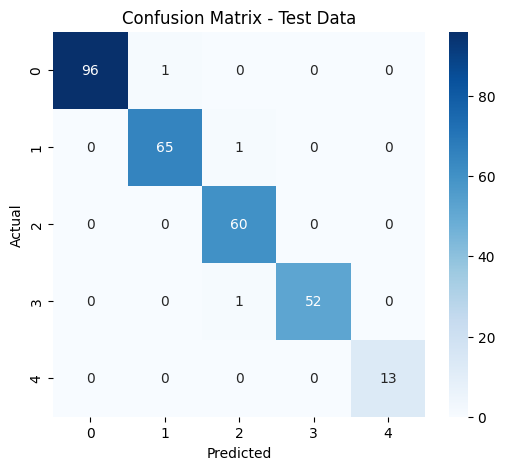

In [ ]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_test_label_names,
            yticklabels=y_test_label_names)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()